### Using DQN to train a stock trading agent

In [1]:
# PYTORCH IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# OTHER USEFUL PYTHON MODULES AND PACKAGES
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import gymnasium as gym
import imageio
# import flappy_bird_gym
import requests
import pandas as pd
import yfinance as yf

# BASE PYTHON IMPORTS
import math
import random
from collections import deque, namedtuple
from itertools import count
import time
from pathlib import Path
torch.autograd.set_detect_anomaly(True)

# SET UP MATPLOTLIB
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [2]:
# check your environment
import sys
print(sys.executable)
print(torch.__file__) 
print(torch.cuda.is_available())
from torch.utils import collect_env
print(collect_env.main())

c:\ProgramData\anaconda3\envs\venv\python.exe
C:\Users\SKYLI\AppData\Roaming\Python\Python39\site-packages\torch\__init__.py
True
PyTorch version: 2.0.0+cu117
Is debug build: False
CUDA used to build PyTorch: 11.7
ROCM used to build PyTorch: N/A

OS: Microsoft Windows 11 Pro
GCC version: Could not collect
Clang version: Could not collect
CMake version: Could not collect
Libc version: N/A

Python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)] (64-bit runtime)
Python platform: Windows-10-10.0.22621-SP0
Is CUDA available: True
CUDA runtime version: 12.1.66
CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA GeForce RTX 3080 Ti
Nvidia driver version: 531.41
cuDNN version: Could not collect
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

CPU:
Architecture=9
CurrentClockSpeed=3600
DeviceID=CPU0
Family=198
L2CacheSize=4096
L2CacheSpeed=
Manufacturer=GenuineIntel
MaxClockSpeed=3600
Name=11th Gen Intel(R) Core(

In [3]:
# run this cell if matplotlib causes python kernel dead
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
# # check your environment
# import sys
# print(sys.executable)
# print(torch.__file__) 
# print(torch.cuda.is_available())
# from torch.utils import collect_env
# print(collect_env.main())

## Define A New Environment to Simulate The Stock Trading

To position the bird on the rightmost side of the screen, the bird's x-coordinate to a fixed value that corresponds to the rightmost edge of the screen. The y-coordinate can be randomized within a range to simulate the starting price of the stock.

To generate the ideal trajectory, sampling from a normal distribution following the Brownian motion to simulate the stock price movements. The mean and standard deviation of the distribution can be adjusted to simulate different market conditions. You can generate a new value at each time step and use it as the position of the pipes in the original Flappy Bird game.

To implement three actions - 'up', 'down', and 'keep' - that correspond to buying, selling, and holding the stock, respectively. These actions will change the bird's y-coordinate, which corresponds to the stock price.

To calculate the reward, comparing the bird's y-coordinate to the ideal trajectory at each time step. If the bird is higher than the trajectory, the reward can be positive, and if it's lower, the reward can be negative. The value of the reward can be determined by the distance between the bird's y-coordinate and the trajectory.

To set the initial reward to 100 and the stop condition to when the reward is below 0 or after 1000 trajectory points, you can initialize the reward to 100 at the start of the game and decrement it by the absolute value of the reward at each time step. The game should stop if the reward falls below 0 or if the game reaches 1000 time steps.

In [5]:
# class StockBirdEnv(gym.Env):
#     def __init__(self):
#         # Define observation space (single continuous variable)
#         self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)

#         # Define action space (discrete with 3 actions)
#         self.action_space = spaces.Discrete(3)

#         # Set initial reward and step count
#         self.reward = 100
#         self.steps = 0

#         # Initialize the figure for rendering
#         self.fig = plt.figure(figsize=(5, 3), dpi=100)

#     def reset(self):
#         # Reset the environment to its initial state
#         self.reward = 100
#         self.steps = 0
#         self.trajectory = np.random.normal(loc=0, scale=1, size=(1000,))

#         # Return the initial state as an observation
#         observation = np.array([0])
#         self.state = observation
#         return observation

#     def step(self, action):
#         # Update the state of the environment based on the agent's action
#         self.steps += 1

#         # Get the current price tick of the stock
#         price_tick = np.random.normal(loc=0, scale=1)

#         # Calculate the distance from the ideal trajectory
#         distance = np.abs(price_tick - self.trajectory[self.steps])

#         # Calculate the reward based on the distance from the trajectory
#         if price_tick > self.trajectory[self.steps]:
#             reward = distance
#         else:
#             reward = -distance

#         # Update the cumulative reward
#         self.reward += reward

#         # Update the state with the new observation
#         observation = np.array([price_tick])
#         self.state = observation

#         # Check if the episode is over
#         done = self.reward < 0 or self.steps >= 1000

#         # Return the observation, reward, done flag, and info dictionary
#         info = {'trajectory': self.trajectory}
#         return observation, reward, done, info

#     def render(self, mode='human'):
#         # Clear the figure and plot the ideal trajectory and the bird's position
#         self.fig.clf()
#         plt.plot(self.trajectory[:self.steps+1], color='gray')
#         plt.plot(self.steps, self.state[0], 'ro', markersize=10)

#         # Add labels and formatting
#         plt.title('Stock Bird Environment')
#         plt.xlabel('Time Step')
#         plt.ylabel('Price Tick')
#         plt.ylim([-5, 5])
#         plt.xlim([0, 1000])

#         # Show the plot
#         plt.show()


## Setup the trading enviroment with single stock

In [6]:
class TradingEnv:
    def __init__(self, stock_data):
        # Load stock data
        self.stock_data = stock_data

        # Calculate percentage change of close price and fill NaN values with 0
        self.stock_data['pct_change'] = pd.Series(self.stock_data['close']).pct_change()
        self.stock_data = self.stock_data.fillna(0)

        # Initialize variables
        self.reset()

    def reset(self):
        # Reset variables to initial values
        self.current_step = 0
        self.current_fund = 1000000
        self.balance = 1000000
        self.position = 0
        self.market_value = 0
        self.daily_profit = 0
        self.total_profit = 0

        # Create observation by concatenating data values and financial variables
        observation = np.concatenate([self.stock_data.iloc[self.current_step].values, 
                                   [self.balance, self.position, self.current_fund]])
        return torch.tensor(observation, dtype=torch.float32)

    # only do one step per day
    def step(self, action):
        # Get initial price and calculate profit from previous action
        current_price = self.stock_data['close'][self.current_step]

        # Sell stocks
        if action < 0:  
            sell_order = math.floor(-action * self.position)
            if sell_order > self.position:  # Cannot sell more than current position
                sell_order = self.position
            self.position -= sell_order
            self.current_fund += sell_order * current_price - sell_order * current_price * 0.005 # Add 0.5% commission fee
            # print('sell size:',sell_order)

        # Buy stocks
        elif action > 0:  
            buy_order = math.ceil(action * self.current_fund / current_price)
            if buy_order * current_price > self.current_fund:  # Cannot buy more than current funds
                buy_order = math.floor(self.current_fund / current_price / 100) * 100
            self.position += buy_order
            self.current_fund -= buy_order * current_price + buy_order * current_price * 0.005 # Add 0.5% commission fee
            # print('buy size:',buy_order)

        else:  # Hold position
            # print('hold')
            pass

        # Calculate the current market value and balance of the account
        self.market_value = self.position * current_price
        self.balance = self.market_value + self.current_fund

        # Calculate daily profit and total profit from initial value of the account
        self.daily_profit = self.position * current_price * self.stock_data['pct_change'][self.current_step]
        self.total_profit = self.balance - 1000000

        # Determine if the episode is done and calculate the reward
        reward = self.daily_profit
        
        # Move to the next bar in the stock data
        self.current_step += 1

        # Create observation by concatenating data values and financial variables
        observation_ = np.concatenate([self.stock_data.iloc[self.current_step].values, 
                                [self.balance, self.position, self.current_fund]])

        # Check if the episode is done
        if self.current_step == len(self.stock_data) - 1:
            done = True
            self.reset()
        else:
            done = False

        # Return the observation, reward, and done flag
        return torch.tensor(observation_), torch.tensor(reward), torch.tensor(done)


## Multistock Environment

In [7]:
# class TradingEnv:
#     def __init__(self, stock_data):
#         # Load stock data
#         self.stock_data = stock_data
#         self.symbols = stock_data['symbol'].unique()

#         # Calculate percentage change of close price and fill NaN values with 0
#         self.stock_data['pct_change'] = self.stock_data.groupby('symbol')['close'].pct_change()
#         self.stock_data = self.stock_data.fillna(0)

#         # Initialize variables
#         self.reset()

#     def reset(self):
#         # Reset variables to initial values
#         self.current_step = 0
#         self.current_fund = 1000000
#         self.balance = 1000000
#         self.position = np.zeros(len(self.symbols))
#         self.market_value = np.zeros(len(self.symbols))
#         self.daily_profit = 0
#         self.total_profit = 0

#         # Create observation by concatenating data values and financial variables
#         observation = self._get_observation()
#         return torch.tensor(observation, dtype=torch.float32)

#     def step(self, action):
#         # Get initial price and calculate profit from previous action
#         current_price = self.stock_data['close'][self.current_step: self.current_step+len(self.symbols)].values

#         if isinstance(action, int): # scalar action
#             action = [action] * len(self.symbols)

#         for i, symbol in enumerate(self.symbols):
#             if action[i] == 0:  # Buy stock
#                 if self.current_fund > current_price[i]:
#                     buy_order = math.floor(self.current_fund / current_price[i] / 100) * 100
#                     self.position[i] += buy_order
#                     self.current_fund = self.current_fund - buy_order * current_price[i] - buy_order * current_price[i] * 0.001

#             elif action[i] == 1:  # Sell stock
#                 if self.position[i] * current_price[i] > 0:
#                     sell_order = math.floor(self.position[i] / 100) * 100
#                     self.position[i] -= sell_order
#                     self.current_fund = self.current_fund + sell_order * current_price[i] - sell_order * current_price[i] * 0.001

#         # Calculate the current market value and balance of the account
#         self.market_value = self.position * current_price
#         self.balance = self.market_value.sum() + self.current_fund

#         # Calculate daily profit and total profit from initial value of the account
#         self.daily_profit = self.position * current_price * self.stock_data['pct_change'][self.current_step: self.current_step+len(self.symbols)].values
#         self.total_profit = self.balance - 1000000

#         # Determine if the episode is done and calculate the reward
#         reward = self.daily_profit.sum()

#         # Move to the next bar in the stock data
#         self.current_step += len(self.symbols)

#         # Create observation by concatenating data values and financial variables
#         observation_ = self._get_observation()

#         # Check if the episode is done
#         if self.current_step >= len(self.stock_data) - len(self.symbols):
#             done = True
#             self.reset()
#         else:
#             done = False

#         # Return the observation, reward, and done flag
#         return torch.tensor(observation_, dtype=torch.float32), torch

## Define the DQN network

In [8]:
class DQN(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,  n_actions):
        super(DQN, self).__init__()
        self.lr = lr
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.BN1 = nn.BatchNorm1d(fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.BN2 = nn.BatchNorm1d(fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        state.to(self.device)
        x = self.fc1(state.to(torch.float32))
        x = F.relu(x)
        # x = self.BN1(x)
        x = self.fc2(x)
        # x = self.BN2(x)
        x = F.relu(x)
        actions = self.fc3(x)
        # print(actions)
        # actions = F.softmax(actions,dim=-1)
        return actions


## Define the Agent

In [9]:
class Agent:
    
    def __init__(self, gamma, epsilon, learning_rate, input_dims, batch_size,
                 memory_size=100000, epsilon_end=0.01, epsilon_decay=1e-5):
        # Initialize hyperparameters and memory parameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.action_space = [-1, 1]  # Continuous action space from -1 to 1
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory_count = 0

        # Initialize the Q network
        self.q_network = DQN(self.learning_rate, input_dims=input_dims, n_actions=1,
                                   fc1_dims=256, fc2_dims=256)

        # Initialize the memory buffers
        self.state_memory = torch.zeros((self.memory_size, *input_dims), dtype=torch.float32)
        self.new_state_memory = torch.zeros((self.memory_size, *input_dims), dtype=torch.float32)
        self.action_memory = torch.zeros(self.memory_size, dtype=torch.float32)
        self.reward_memory = torch.zeros(self.memory_size, dtype=torch.float32)
        self.terminal_memory = torch.zeros(self.memory_size, dtype=torch.bool)

    # Store the transition tuple (state, action, reward, next_state, done) in memory
    def store_transition(self, state, action, reward, next_state, done):
        # Calculate the index of the next memory slot to use, and store the transition there
        index = self.memory_count % self.memory_size
        self.state_memory[index] = state.clone().detach()
        self.new_state_memory[index] = next_state.clone().detach()
        self.reward_memory[index] = torch.tensor(reward).clone().detach()
        self.action_memory[index] = torch.tensor(action).clone().detach()
        self.terminal_memory[index] = torch.tensor(done).clone().detach()

        # Increment the memory counter
        self.memory_count += 1
        # print('memory index: ', index)

    # The observation variable represents the state
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # Choose the action with the highest value (greedy exploration)
            state = torch.tensor(observation, device=self.q_network.device).to(torch.float32)
            # Get the action from the neural network model
            action = torch.tanh(self.q_network.forward(state)).item()
        else:
            # Choose a random action (exploration)
            action = np.random.uniform(low=-1, high=1)
        return action

    def learn(self):
      # If the memory counter is less than the batch size, return
      if self.memory_count < self.batch_size:
          return

      # Initialize the gradients to 0
      self.q_network.optimizer.zero_grad()

      # Get the memory size, not exceeding the memory limit
      max_mem = min(self.memory_count, self.memory_size)

      # Randomly generate a batch index with the option to choose the same index multiple times
      batch = np.random.choice(max_mem, self.batch_size, replace=False)

      state_batch = self.state_memory[batch].to(self.q_network.device)
      new_state_batch = self.new_state_memory[batch].to(self.q_network.device)
      reward_batch = self.reward_memory[batch].to(self.q_network.device)
      terminal_batch = self.terminal_memory[batch].to(self.q_network.device)

      # Get the action for this batch
      action_batch = torch.tensor(self.action_memory[batch], device=self.q_network.device, dtype=torch.float32)

      # Compute the Q-values for the current state
      q_eval_all = self.q_network.forward(state_batch)
      q_eval = torch.sum(q_eval_all * action_batch, dim=1)  # Compute Q-value for the chosen action

      # Compute the Q-values for the next state
      q_next = self.q_network.forward(new_state_batch)

      # Set the Q-values for terminal states to 0
      q_next[terminal_batch] = torch.tensor(0.0)

      # Compute the Q-targets using the Bellman equation
      q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]

      # Compute the loss between the predicted Q-values (q_eval) and the target Q-values (q_target)
      loss = self.q_network.loss(q_target, q_eval).to(self.q_network.device)

      # Compute gradients and update weights
      loss.backward()
      self.q_network.optimizer.step()

      # Decay the epsilon value for epsilon-greedy exploration
      self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_min \
          else self.epsilon_min

        
    # Save the trained model
    def save_model(self, filepath):
        torch.save(self.q_network, f=filepath)
        print('Model saved to: ', filepath)

    # Load the trained model
    def load_model(self, filepath):
        self.q_network = torch.load(f=filepath)
        print('Model loaded from: ', filepath)

## Plot function

In [10]:
episode_durations = []
episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def plot_rewards(show_result=False):
    # SET THE CURRENT FIGURE
    plt.figure(1)

    # IF TRAINING IS COMPLETE
    if show_result:
        plt.title(f'Result (Episode {i_episode + 1} Highest Reward: {max(episode_rewards)})')
    
    # IF STILL TRAINING   
    else:
        plt.clf()
        plt.title(f'Training... Eps: {i_episode + 1} Current Reward: {cum_reward} Highest Reward: {max(episode_rewards)}')
    
    # SET LABELS AND PLOT DATA
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.plot(episode_rewards, label='Strategy')
    # Compute the baseline return
    baseline_return = (train_data.iloc[-1]['close']/train_data.iloc[0]['close']-1)*1000000
    # Create a list of baseline returns with the same length as episode_rewards
    baseline_returns = [baseline_return] * len(episode_rewards)
    # Plot the baseline returns
    plt.plot(baseline_returns, label='Holding')
    # PAUSE SO THAT PLOTS CAN BE UPDATED
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            # WAIT UNTIL NEW OUTPUT AVAILABLE TO CLEAR CURRENT FIGURE
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Start training

In [11]:
# the train data is from 2002-01-01 to 2020-12-31
# train_data = pd.read_csv('./stock_data/JPM_train_long.csv')
# the train data is from 2018-01-01 to 2020-12-31
train_data = pd.read_csv('./stock_data/JPM_train_short.csv')

# Create the trading environment

env = TradingEnv(train_data)

# Create the agent with the specified hyperparameters
agent = Agent(gamma=0.99, epsilon=1, batch_size=64, epsilon_end=0.01, input_dims=[11], learning_rate=0.005)

start_time = time.time()

# Set the number of episodes to simulate
num_episodes = 500

# Initialize episode_rewards and episode_durations to empty lists
episode_rewards, episode_durations, eps_history = [], [], []

# Play num_episodes episodes
for i_episode in range(num_episodes):

    # Initialize the cumulative reward and done variables and reset the environment
    cum_reward = 0
    done = False
    observation = env.reset()

    # Play an episode until it is done
    while not done:

        # Choose an action using the agent's policy and take a step in the environment
        action = agent.choose_action(observation)
        observation_, reward, done = env.step(action)

        # Update the cumulative reward, store the transition in the agent's memory, and learn from it
        cum_reward += reward
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()

        # Update the observation for the next timestep
        observation = observation_

    # Append the final cumulative reward and epsilon values for this episode to the lists
    episode_rewards.append(cum_reward)
    eps_history.append(agent.epsilon)

    # Compute the average reward over the last 100 episodes
    avg_reward = np.mean(episode_rewards[-10:])

    # Print the episode number, the cumulative reward, the average reward, and the current epsilon
    print('Episode:', i_episode+1, 'Cumulative Reward: %.2f' % cum_reward, 'Average Reward (last 10 episodes): %.2f' % avg_reward, 'Epsilon: %.4f' % agent.epsilon)
    # print(env.total_profit)
    # Add the episode duration to the list of episode durations
    episode_durations.append(env.current_step)

    
    # Plot the rewards
    plot_rewards()

# Create a list of episode numbers for plotting
x = [i_episode + 1 for i_episode in range(num_episodes)]

# # Plot the rewards over the episodes
# plt.plot(x, episode_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Cumulative Reward')
# plt.title('Cumulative Reward vs Episode')

# # Show the plot
# plt.show()
print('Complete')
end_time = time.time()
plot_rewards(show_result=True)
plt.ioff()
plt.show()
print(end_time - start_time)

C:\Users\SKYLI\AppData\Local\Temp\ipykernel_15272\574483453.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.reward_memory[index] = torch.tensor(reward).clone().detach()
C:\Users\SKYLI\AppData\Local\Temp\ipykernel_15272\574483453.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.terminal_memory[index] = torch.tensor(done).clone().detach()
C:\Users\SKYLI\AppData\Local\Temp\ipykernel_15272\574483453.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_batch = torch.tensor(self.action_memory[batch], device=self.q_netw

Episode: 5 Cumulative Reward: 313011.77 Average Reward (last 10 episodes): 208452.39 Epsilon: 0.7553


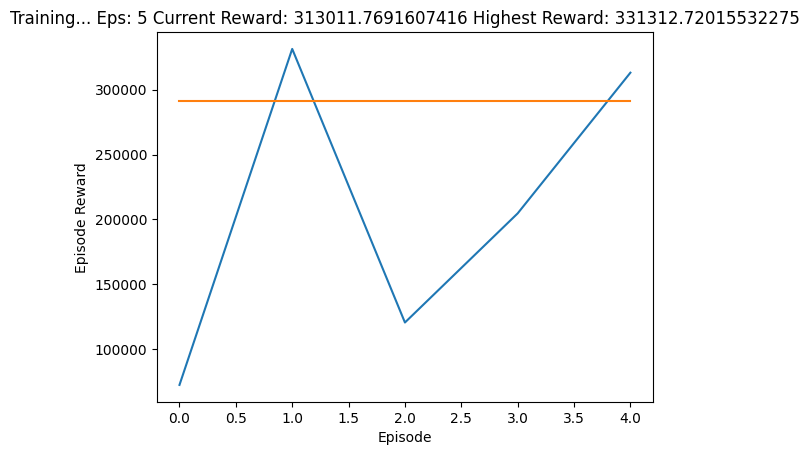

<Figure size 640x480 with 0 Axes>

In [ ]:
# # the train data is from 2002-01-01 to 2020-12-31
# # train_data = pd.read_csv('./stock_data/JPM_train_long.csv')
# # the train data is from 2018-01-01 to 2020-12-31
# train_data = pd.read_csv('./stock_data/JPM_train_short.csv')

# # Create the trading environment

# env = TradingEnv(train_data)

# # Create the agent with the specified hyperparameters
# agent = Agent(gamma=0.99, epsilon=1, batch_size=64, epsilon_end=0.01, input_dims=[11], learning_rate=0.001)

# start_time = time.time()

# # Set the number of episodes to simulate
# num_episodes = 20

# # Initialize episode_rewards and episode_durations to empty lists
# episode_rewards, episode_durations, eps_history = [], [], []

# # Play num_episodes episodes
# for i_episode in range(num_episodes):

#     # Initialize the cumulative reward and done variables and reset the environment
#     cum_reward = 0
#     done = False
#     observation = env.reset()

#     # Play an episode until it is done
#     while not done:

#         # Choose an action using the agent's policy and take a step in the environment
#         action = np.random.normal(loc=0.0, scale=1.0, size=1)[0]
#         observation_, reward, done = env.step(action)

#         # Update the cumulative reward, store the transition in the agent's memory, and learn from it
#         cum_reward += reward
#         agent.store_transition(observation, action, reward, observation_, done)
#         agent.learn()

#         # Update the observation for the next timestep
#         observation = observation_

#     # Append the final cumulative reward and epsilon values for this episode to the lists
#     episode_rewards.append(cum_reward)
#     eps_history.append(agent.epsilon)

#     # Compute the average reward over the last 100 episodes
#     avg_reward = np.mean(episode_rewards[-10:])

#     # Print the episode number, the cumulative reward, the average reward, and the current epsilon
#     print('Episode:', i_episode+1, 'Cumulative Reward: %.2f' % cum_reward, 'Average Reward (last 10 episodes): %.2f' % avg_reward, 'Epsilon: %.4f' % agent.epsilon)
#     # print(env.total_profit)
#     # Add the episode duration to the list of episode durations
#     episode_durations.append(env.current_step)

    
#     # Plot the rewards
#     plot_rewards()

# # Create a list of episode numbers for plotting
# x = [i_episode + 1 for i_episode in range(num_episodes)]

# # # Plot the rewards over the episodes
# # plt.plot(x, episode_rewards)
# # plt.xlabel('Episode')
# # plt.ylabel('Cumulative Reward')
# # plt.title('Cumulative Reward vs Episode')

# # # Show the plot
# # plt.show()
# print('Complete')
# end_time = time.time()
# plot_rewards(show_result=True)
# plt.ioff()
# plt.show()
# print(end_time - start_time)

In [ ]:
# save the model
path = Path('./models/JPM_stock_dqn.pth')
agent.save_model(path)

## Test of the trained agents

In [ ]:
### the test data is from 2020-01-01 to 2022-12-31 
path = Path('./models/JPM_stock_dqn.pth')
# Create the trading environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = TradingEnv(pd.read_csv('./stock_data/JPM_test.csv'))

# Create the agent with the specified hyperparameters
agent = Agent(gamma=0.99, epsilon=1, batch_size=64, epsilon_end=0.01, input_dims=[11], learning_rate=0.001)
agent.load_model(path)

In [ ]:
# Simulate trading using the trained policy network for 20 episodes
num_episodes = 20
episode_rewards = []

# Initialize episode_rewards and episode_durations to empty lists
episode_rewards, episode_durations, eps_history = [], [], []

# Set the device to CUDA if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize lists to store position and profit state during each episode
position_history, profit_history = [], []

for i_episode in range(num_episodes):
    state = env.reset()
    cum_reward = 0

    # Initialize position and profit state for current episode
    position_state = [env.position]
    profit_state = [env.total_profit]

    while True:
        # Convert state to tensor and add a batch dimension
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # Get the action with the highest Q-value from the agent's neural network
        action = agent.choose_action(state)

        # Take the chosen action and get the next state, reward, and done flag from the environment
        next_state, reward, done = env.step(action)

        # Add the reward to the cumulative reward for the episode
        cum_reward += reward

        # Store the transition tuple (state, action, reward, next_state, done) in the agent's memory buffer
        agent.store_transition(state, action, reward, next_state, done)

        # Update position and profit state for current episode
        position_state.append(env.position)
        profit_state.append(env.total_profit)

        if done:
            episode_rewards.append(cum_reward)
            print("Episode {}: Cumulative Reward = {}".format(i_episode+1, cum_reward))
            break

    # Store position and profit state for current episode
    position_history.append(position_state)
    profit_history.append(profit_state)

# Print the average rewards over 20 episodes
avg_reward = sum(episode_rewards) / len(episode_rewards)
std_reward = np.std(episode_rewards)
print("Average Reward over 20 Episodes = {:.2f}".format(avg_reward))
print("Standard Deviation of Rewards over 20 Episodes = {:.2f}".format(std_reward))

C:\Users\SKYLI\AppData\Local\Temp\ipykernel_6980\3037978373.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
C:\Users\SKYLI\AppData\Local\Temp\ipykernel_6980\1996425800.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.reward_memory[index] = torch.tensor(reward).clone().detach()
C:\Users\SKYLI\AppData\Local\Temp\ipykernel_6980\1996425800.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.terminal_memory[index] = torch.tensor(done).clone().detac

Episode 1: Cumulative Reward = 156824.73173761132
Episode 2: Cumulative Reward = 67742.00902148083
Episode 3: Cumulative Reward = 193889.73696153203
Episode 4: Cumulative Reward = -15276.402661719441
Episode 5: Cumulative Reward = -19499.845157794927
Episode 6: Cumulative Reward = 92341.7022828419
Episode 7: Cumulative Reward = 35547.00865522172
Episode 8: Cumulative Reward = 56597.42294985575
Episode 9: Cumulative Reward = 60180.36031512646
Episode 10: Cumulative Reward = 265467.8900435007
Episode 11: Cumulative Reward = -60857.989021056834
Episode 12: Cumulative Reward = -165192.26587619793
Episode 13: Cumulative Reward = 167090.91048169407
Episode 14: Cumulative Reward = -27863.738579836376
Episode 15: Cumulative Reward = -137540.42207919466
Episode 16: Cumulative Reward = 108062.43578741189
Episode 17: Cumulative Reward = 301281.05496425676
Episode 18: Cumulative Reward = -36767.20923604218
Episode 19: Cumulative Reward = -48896.667211656284
Episode 20: Cumulative Reward = 268980.5

## Plot the reward curves and position states

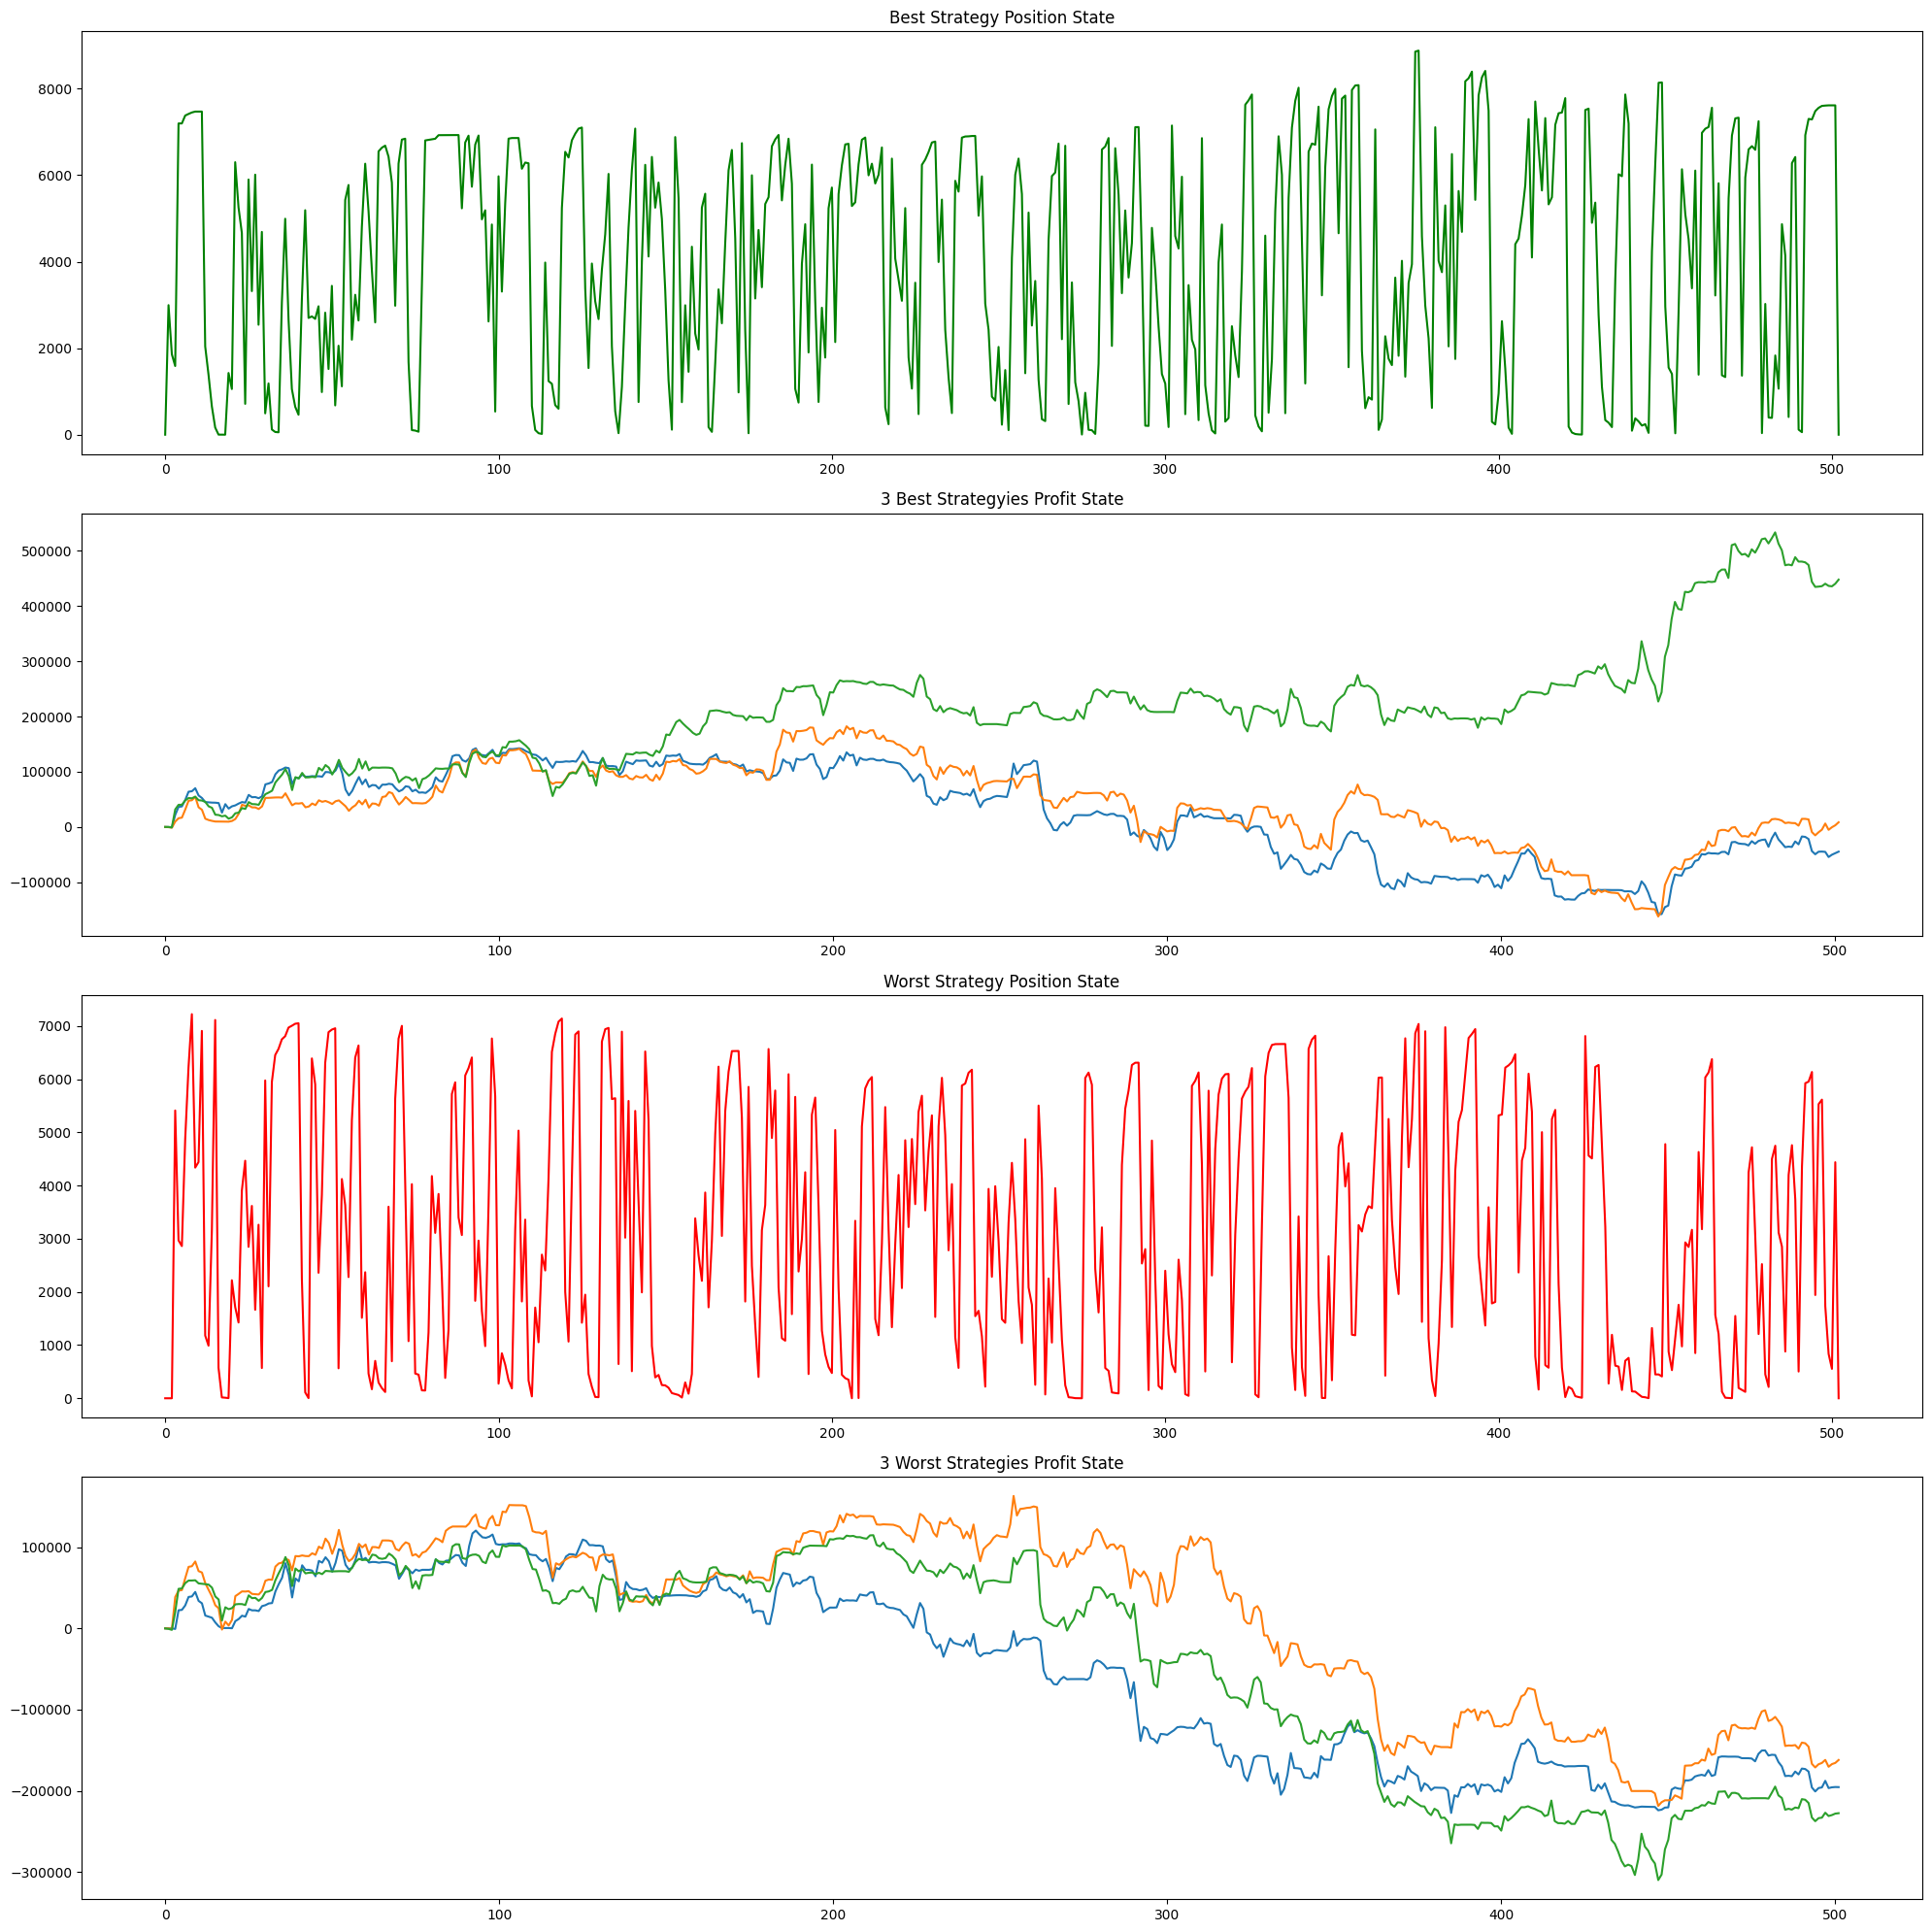

In [ ]:
# Plot position and profit state for each episode
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

# Sort episode rewards in descending order
sorted_episode_rewards = sorted(enumerate(episode_rewards), key=lambda x: x[1], reverse=True)

# Get indices of the highest 3 and lowest 3 episode rewards
highest_indices = [i for i, _ in sorted_episode_rewards[:3]]
lowest_indices = [i for i, _ in sorted_episode_rewards[-3:]]

ax[0].plot(position_history[highest_indices[0]], label="Episode {} (Highest Reward)".format(1), color='green')
ax[0].set_title('Best Strategy Position State')
ax[2].plot(position_history[lowest_indices[0]], label="Episode {} (Lowest Reward)".format(1), color='red')
ax[2].set_title('Worst Strategy Position State')

for i in range(num_episodes):
    
    if i in highest_indices:
        # Plot position and profit state for the highest 3 episode rewards
        ax[1].plot(profit_history[i][:-1], label="Episode {} (Highest Reward)".format(i+1))
        
    elif i in lowest_indices:
        # Plot position and profit state for the lowest 3 episode rewards
        ax[3].plot(profit_history[i][:-1], label="Episode {} (Lowest Reward)".format(i+1))

ax[1].set_title('3 Best Strategyies Profit State')
ax[3].set_title('3 Worst Strategies Profit State')

# Display the plot
plt.tight_layout()
plt.show()
